In [1]:
from network_evaluation_tools import gene_conversion_tools as gct
from network_evaluation_tools import data_import_tools as dit
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
wd = '/cellar/users/snwright/Data/Network_Analysis/'

# Version 2.0

## Load STRING Raw Data
#### Source https://stringdb-static.org/download/protein.links.v11.5/9606.protein.links.v11.5.txt.gz
Downloaded: Oct 30, 2021 
Last Updated: August 12, 2021

**Notes:** 
* Could also look at using 9606.protein.links.full.v11.5.txt.gz (133.6 Mb)	protein network data (incl. distinction: direct vs. interologs)

In [17]:
# 2021: Direct download of STRING data is the same as original filtered data
STRING_Raw_v2 = pd.read_csv(wd+'Network_Data_Raw/STRING/9606.protein.links.v11.5.txt.gz',sep='\s+')
STRING_Raw_v2.columns = ['NodeA', 'NodeB', 'Score']
print('Raw Edges in STRING v11.5:', len(STRING_Raw_v2))

Raw Edges in STRING v11.5: 11938498


In [18]:
STRING_Raw_filt_v2 = STRING_Raw_v2.drop_duplicates()
print('Edges in STRING v11.5 after dropping duplicates:', len(STRING_Raw_filt_v2))

Edges in STRING v11.5 after dropping duplicates: 11938498


In [20]:
STRING_Raw_filt_v2["NodeA"] = [x.split("9606.")[1] if "9606." in x else x for x in STRING_Raw_filt_v2["NodeA"].values]
STRING_Raw_filt_v2["NodeB"] = [x.split("9606.")[1] if "9606." in x else x for x in STRING_Raw_filt_v2["NodeB"].values]

In [21]:
STRING_Genes_v2 = list(set(STRING_Raw_filt_v2['NodeA']).union(set(STRING_Raw_filt_v2['NodeB'])))

In [22]:
query_edgelist_v2 = STRING_Raw_filt_v2[['NodeA', 'NodeB', 'Score']].values.tolist()

## Convert Genes from Ensembl Protein to Hugo Symbol

In [23]:
query_string_v2, valid_genes_v2, invalid_genes_v2 = gct.query_constructor(STRING_Genes_v2)

19385 Valid Query Genes
0 Invalid Query Genes


In [24]:
# Set scopes (gene naming systems to search)
scopes = "ensemblprotein"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list_v2 = gct.query_batch(query_string_v2, scopes=scopes, fields=fields)

100%|██████████| 20/20 [00:16<00:00,  1.19it/s]

19385 Matched query results
Batch query complete: 16.95 seconds


In [25]:
# Original 1584
match_table_trim_v2, query_to_symbol_v2, query_to_entrez_v2 = gct.construct_query_map_table(match_list_v2, valid_genes_v2)

Queries without full matching results found: 942

0 Queries with mutliple matches found

Query mapping table/dictionary construction complete: 3.93 seconds


## Construct Converted Network

In [26]:
%%time
# Convert weighted edge list
STRING_edgelist_symbol_v2 = gct.convert_edgelist(query_edgelist_v2, query_to_symbol_v2, weighted=True)

CPU times: user 6.27 s, sys: 422 ms, total: 6.69 s
Wall time: 6.73 s


In [28]:
# Filter converted edge list
STRING_edgelist_symbol_filt_v2 = gct.filter_converted_edgelist(STRING_edgelist_symbol_v2, weighted=True)

11938498 input edges
40 self-edges removed
781006 edges with un-mapped genes removed
5594574 duplicate edges removed
Edge list filtered: 32.62 seconds
5562878 Edges remaining


In [29]:
# Write network to file
gct.write_edgelist(STRING_edgelist_symbol_filt_v2, wd+'Processed_Data/Network_SIFs_Symbol/STRING_Symbol_11_5.sif', binary=False)

Edge list saved: 7.68 seconds


In [30]:
# Create filtered network
STRING90_edgelist_v2 = dit.filter_weighted_network_sif(wd+'Processed_Data/Network_SIFs_Symbol/STRING_Symbol_11_5.sif', nodeA_col=0, nodeB_col=1, score_col=2, 
                                                    q=0.9, delimiter='\t', verbose=True, 
                                                       save_path=wd+'Processed_Data/Network_SIFs_Symbol/STRING90_Symbol_11_5.sif')

90.0% score: 490.0
555617 / 5562878 edges retained


# Version 1.0 (original)

## Load STRING Raw Data
#### Source: http://string-db.org/download/protein.links.v10.5.txt.gz
#### Source (detailed): http://string-db.org/download/protein.links.detailed.v10.5.txt.gz
#### File to download: The link labelled 'protein.links.v10.5.txt.gz' is simply the binary file version of the 'detailed' file. The detailed file documents the types of interactions and support for each interaction. It can be used for filtering in the future if desired, but will not be filtered on those categories currently.
Downloaded: June 15, 2016  
Last Updated: May 14, 2017	
Processing note: This data needs to be filtered for human-only interactions. This is a very long and large file, so we will parse the edges that are human-human interactions only by streaming the file. Then the resulting human-human interaction file will be read to be processed.

**2021 Notes:** 
* It is no longer necessary to download the full dataset and filter for human-human interactions as this is provided directly by STRING (https://stringdb-static.org/download/protein.links.v10.5/9606.protein.links.v10.5.txt.gz)

In [8]:
# Load and filter STRING for only human-human protein interactions
# wd = '/cellar/users/jkhuang/Data/Projects/Network_Analysis/Data/'
# starttime=time.time()
# g=open(wd+'Network_Data_Raw/STRING/STRING_human_v10.5.txt','w')
# with open(wd+'Network_Data_Raw/STRING/protein.links.v10.5.txt') as f:
#     for line in f:
#         edge = line.split(' ')
#         if edge[0].startswith('9606') and edge[1].startswith('9606'):
#             g.write(edge[0].split('.')[1]+'\t'+edge[1].split('.')[1]+'\t'+edge[2]+'\n')
# print 'Filtered human-human STRING interactions only:', time.time()-starttime, 'seconds'
# g.close()

## Load human-filtered STRING edges

In [3]:
STRING_Raw = pd.read_csv(wd+'Network_Data_Raw/STRING/STRING_human_v10.5.txt',sep='\t',header=None)
STRING_Raw.columns = ['NodeA', 'NodeB', 'Score']
print('Raw Edges in STRING v10.5:', len(STRING_Raw))

Raw Edges in STRING v10.5: 11353056


In [4]:
# 2021: Direct download of STRING data is the same as original filtered data
STRING_Raw = pd.read_csv(wd+'Network_Data_Raw/STRING/9606.protein.links.v10.5.txt.gz',sep='\s+')
STRING_Raw.columns = ['NodeA', 'NodeB', 'Score']
print('Raw Edges in STRING v10.5:', len(STRING_Raw))

Raw Edges in STRING v10.5: 11353056


In [5]:
STRING_Raw_filt = STRING_Raw.drop_duplicates()
print('Edges in STRING v10.5 after dropping duplicates:', len(STRING_Raw_filt))

Edges in STRING v10.5 after dropping duplicates: 11353056


In [6]:
STRING_Raw_filt["NodeA"] = [x.split("9606.")[1] if "9606." in x else x for x in STRING_Raw_filt["NodeA"].values]
STRING_Raw_filt["NodeB"] = [x.split("9606.")[1] if "9606." in x else x for x in STRING_Raw_filt["NodeB"].values]

In [12]:
STRING_Raw_filt.head()

,NodeA,NodeB,Score
0,ENSP00000000233,ENSP00000263431,260
1,ENSP00000000233,ENSP00000353863,164
2,ENSP00000000233,ENSP00000342026,159
3,ENSP00000000233,ENSP00000240874,194
4,ENSP00000000233,ENSP00000379847,164


In [7]:
STRING_Genes = list(set(STRING_Raw_filt['NodeA']).union(set(STRING_Raw_filt['NodeB'])))

In [8]:
query_edgelist = STRING_Raw_filt[['NodeA', 'NodeB', 'Score']].values.tolist()

## Convert Genes from Ensembl Protein to Hugo Symbol

In [9]:
query_string, valid_genes, invalid_genes = gct.query_constructor(STRING_Genes)

19576 Valid Query Genes
0 Invalid Query Genes


In [10]:
# Set scopes (gene naming systems to search)
scopes = "ensemblprotein"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list = gct.query_batch(query_string, scopes=scopes, fields=fields)

100%|██████████| 20/20 [00:16<00:00,  1.21it/s]

19576 Matched query results
Batch query complete: 16.65 seconds


In [11]:
# Original 1584
match_table_trim, query_to_symbol, query_to_entrez = gct.construct_query_map_table(match_list, valid_genes)

Queries without full matching results found: 2044

0 Queries with mutliple matches found

Query mapping table/dictionary construction complete: 4.5 seconds


## Construct Converted Network

In [12]:
%%time
# Convert weighted edge list
STRING_edgelist_symbol = gct.convert_edgelist(query_edgelist, query_to_symbol, weighted=True)

CPU times: user 6.02 s, sys: 386 ms, total: 6.41 s
Wall time: 6.9 s


In [19]:
# Filter converted edge list
# Original: 
# 11353056 input edges
# 30268 self-edges removed
# 1043874 edges with un-mapped genes removed
# 5143146 duplicate edges removed
# Edge list filtered: 77.42 seconds
# 5135768 Edges remaining
# STRING_edgelist_symbol_filt = gct.filter_converted_edgelist(STRING_edgelist_symbol, weighted=True)

11353056 input edges
12 self-edges removed
1723570 edges with un-mapped genes removed
4764 duplicate edges removed
Edge list filtered: 6.17 seconds
9624710 Edges remaining


In [13]:
# Filter converted edge list
STRING_edgelist_symbol_filt = gct.filter_converted_edgelist(STRING_edgelist_symbol, weighted=True)

11353056 input edges
12 self-edges removed
1723570 edges with un-mapped genes removed
4817119 duplicate edges removed
Edge list filtered: 27.97 seconds
4812355 Edges remaining


In [15]:
# Write network to file
gct.write_edgelist(STRING_edgelist_symbol_filt, wd+'Processed_Data/Network_SIFs_Symbol/STRING_Symbol_10_5.sif', binary=False)

Edge list saved: 6.62 seconds


In [27]:
# Create filtered network
STRING90_edgelist = dit.filter_weighted_network_sif(wd+'Processed_Data/Network_SIFs_Symbol/STRING_Symbol_10_5.sif', nodeA_col=0, nodeB_col=1, score_col=2, 
                                                    q=0.9, delimiter='\t', verbose=True, 
                                                    save_path=wd+'Processed_Data/Network_SIFs_Symbol/STRING90_Symbol_10_5.sif')

90.0% score: 500.0
480895 / 4812355 edges retained


# Changes

* We can now download just the human interaction network. This saves disk space and removes need for filtering. 
* Gene identifiers are prefixed with "9606." so this needs to be removed before processing

In [32]:
stats = pd.DataFrame({"v1":[11353056, 4817119, 4812355], 
                           "v2":[11938498, 5594574, 5562878]},
                           index=["input", "duplicates", "filtered"])

In [31]:
nodes_v1 = set(np.array(STRING_edgelist_symbol_filt)[:, 0]).union(set(np.array(STRING_edgelist_symbol_filt)[:, 1]))
nodes_v2 = set(np.array(STRING_edgelist_symbol_filt_v2)[:, 0]).union(set(np.array(STRING_edgelist_symbol_filt_v2)[:, 1]))


Text(0, 0.5, 'Number of nodes')

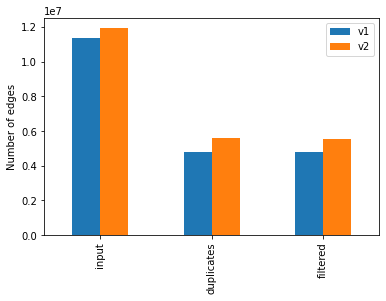

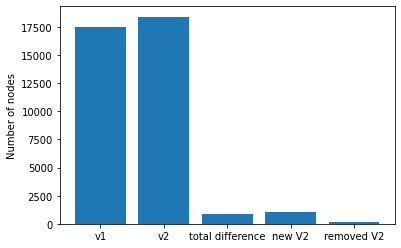

In [33]:
stats.plot.bar(ylabel="Number of edges")
plt.figure()
plt.bar(["v1", "v2", "total difference", "new V2", "removed V2"], [len(nodes_v1), len(nodes_v2), len(nodes_v2)-len(nodes_v1),
                                                           len(nodes_v2.difference(nodes_v1)), len(nodes_v1.difference(nodes_v2))])
plt.ylabel("Number of nodes")